In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import oscarplus as op
import plot_helpers as ph
import subplots as splot
from numpy import sin, deg2rad

In [2]:
# select files
dates = ["20220517", "20220522"]
tracks_17 = ["1", "2"]
tracks_22 = ["1", "1b", "2", "2b"]
gmf = "mouche12kp20_rsv20"
resolution = "200x200m"

# input for plotting


In [ ]:
# functions
def import_prepare_OSCAR(date, track, datasets, datasets_coarsened, downscale_factor):
    # Load the dataset for the current track
    L2a_MF, _ = op.tools.readers.read_OSCAR(date, track, gmf, "L2a MF", resolution)
    L2a_MF = op.processing.secondary_products.calculate_secondary_products(L2a_MF)
    # Add a new coordinate for the track
    L2a_MF = L2a_MF.assign_coords(datetrack=f"{date}_{track}")

    # Store the dataset in the list
    datasets.append(L2a_MF)

    # Coarsen the dataset
    L2a_MF_coarsened = op.processing.filtering.downscale(L2a_MF, downscale_factor)

    # Re-calculate secondary products
    op.processing.secondary_products.calculate_secondary_products(L2a_MF_coarsened)
    datasets_coarsened.append(L2a_MF_coarsened)
    return datasets, datasets_coarsened

In [4]:
# Read the datasets
datasets = []
datasets_coarsened = []
downscale_factor = 5

# Loop through tracks and read datasets
date = dates[0]
for track in tracks_17:
    datasets, datasets_coarsened = import_prepare_OSCAR(
        date, track, datasets, datasets_coarsened, downscale_factor
    )
date = dates[1]
for track in tracks_22:
    datasets, datasets_coarsened = import_prepare_OSCAR(
        date, track, datasets, datasets_coarsened, downscale_factor
    )

In [5]:
def divide_by_f(DS):
    f = (
        2
        * 7.2921e-5
        * sin(
            deg2rad((DS["latitude"].max() + DS["latitude"].min()) / 2)
        )  # take an average of the latitudes
    )
    DS["CurrentShearRate"] = DS["CurrentShearRate"] / f
    DS["CurrentStrainRate"] = DS["CurrentStrainRate"] / f
    return DS

for DS in datasets:
    DS = divide_by_f(DS)
for DS in datasets_coarsened:
    DS = divide_by_f(DS)
    

In [6]:
# Merge the datasets
merged_dataset = xr.concat(datasets, dim="datetrack")
merged_dataset_coarsened = xr.concat(datasets_coarsened, dim="datetrack")

Min Current Divergence 200m: -39.49297807828041
Max Current Divergence 200m: 38.02609205802761
Min Current Divergence 1km: -7.049565245623943
Max Current Divergence 1km: 9.68829566632676
Min Current Curl 200m: -19.35679791252511
Max Current Curl 200m: 36.59471930064951
Min Current Curl 1km: -5.551403592566349
Max Current Curl 1km: 14.392848957585631
Min Current ShearRate 200m: -39.28607450913725
Max Current ShearRate 200m: 45.8413641629874
Min Current ShearRate 1km: -17.95388942663794
Max Current ShearRate 1km: 14.95525139256605
Min Current StrainRate 200m: 0.06684965110337907
Max Current StrainRate 200m: 46.79172697037477
Min Current StrainRate 1km: 0.27918263730079057
Max Current StrainRate 1km: 18.125225380883464


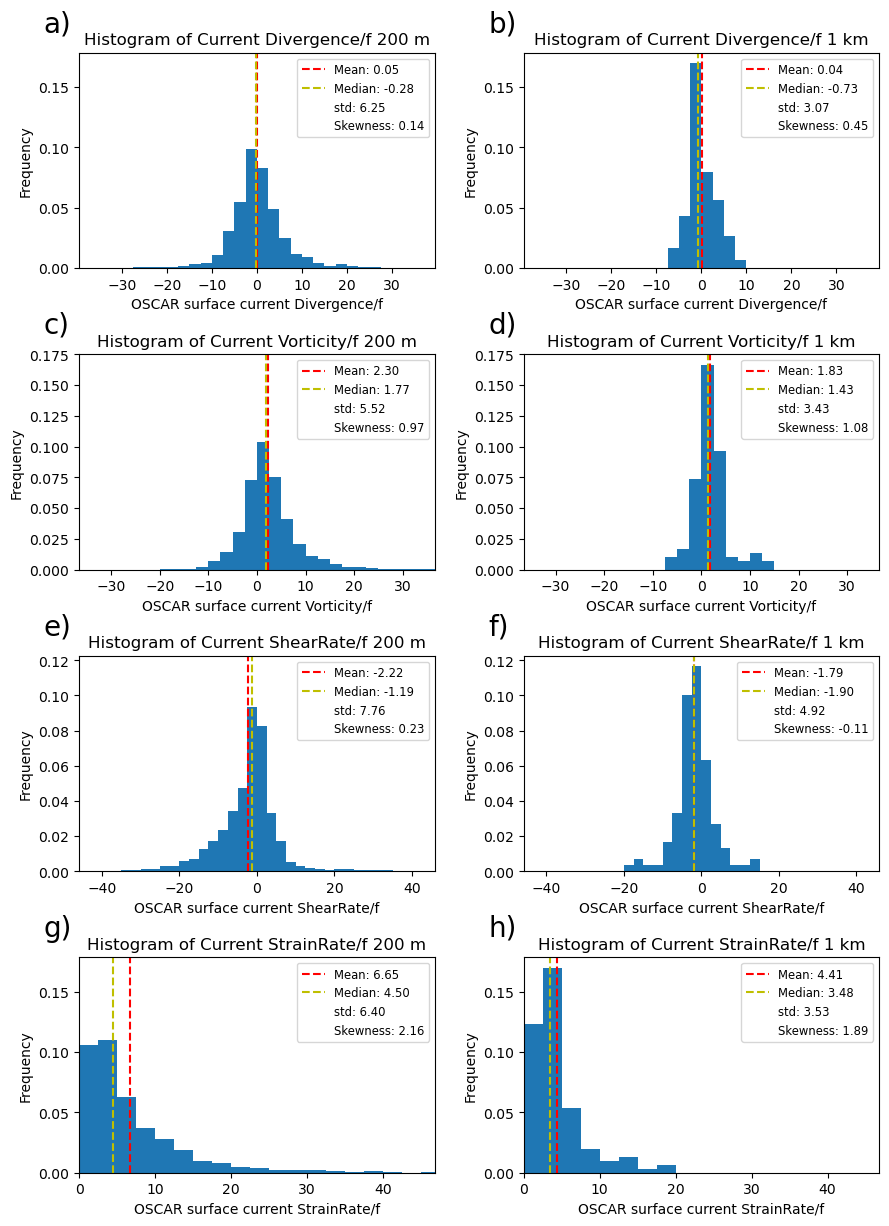

In [7]:
# Figures
fig, axes = plt.subplots(4, 2, figsize=(10, 14))

def plot_row_stats(axes_row, variable, bin_width, zero_centered=True):
    # For the histograms, we want to have the same x-axis limits for both plots
    xlim = max(
        abs(np.nanmax(merged_dataset[f"Current{variable}"].values)),
        abs(np.nanmax(merged_dataset_coarsened[f"Current{variable}"].values)),
        abs(np.nanmin(merged_dataset[f"Current{variable}"].values)),
        abs(np.nanmin(merged_dataset_coarsened[f"Current{variable}"].values)),
    )
            
    if not zero_centered:
        xlim = [0, xlim]

    if variable == "Curl":
        title_variable = "Vorticity"
    else:
        title_variable = variable

    # Histograms
    splot.histogram_with_stats(
        merged_dataset[f"Current{variable}"],
        f"Current {title_variable}/f 200 m",
        axes_row[0],
        xlim=xlim,
        bin_width=bin_width,
        variable=title_variable,
    )
    splot.histogram_with_stats(
        merged_dataset_coarsened[f"Current{variable}"],
        f"Current {title_variable}/f 1 km",
        axes_row[1],
        xlim=xlim,
        bin_width=bin_width,
        variable=title_variable,
    )

    # Set the same y-axis limits for both histograms
    ylim = max(axes_row[0].get_ylim()[1], axes_row[1].get_ylim()[1])
    axes_row[0].set_ylim(0, ylim)
    axes_row[1].set_ylim(0, ylim)

    # Print the min and max values of the histograms
    print(
        f"Min Current {variable} 200m:",
        merged_dataset[f"Current{variable}"].min().values,
    )
    print(
        f"Max Current {variable} 200m:",
        merged_dataset[f"Current{variable}"].max().values,
    )
    print(
        f"Min Current {variable} 1km:",
        merged_dataset_coarsened[f"Current{variable}"].min().values,
    )
    print(
        f"Max Current {variable} 1km:",
        merged_dataset_coarsened[f"Current{variable}"].max().values,
    )

plot_row_stats(axes[0], "Divergence", bin_width = 2.5)
plot_row_stats(axes[1], "Curl", bin_width = 2.5)
plot_row_stats(axes[2], "ShearRate", bin_width = 2.5)
plot_row_stats(axes[3], "StrainRate", bin_width = 2.5, zero_centered=False)

# Add letters to the subplots and adjust the layout
ph.add_letters(axes)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.25, hspace=0.4)

In [8]:
datasets[0]

<xarray.Dataset>
Dimensions:                                (CrossRange: 46, GroundRange: 11)
Coordinates:
  * GroundRange                            (GroundRange) float64 840.0 ... 2....
  * CrossRange                             (CrossRange) float64 -4.548e+03 .....
    latitude                               (CrossRange, GroundRange) float64 ...
    longitude                              (CrossRange, GroundRange) float64 ...
    datetrack                              <U10 '20220517_1'
Data variables: (12/29)
    cost                                   (CrossRange, GroundRange) float64 ...
    CurrentU                               (CrossRange, GroundRange) float64 ...
    CurrentV                               (CrossRange, GroundRange) float64 ...
    EarthRelativeWindU                     (CrossRange, GroundRange) float64 ...
    EarthRelativeWindV                     (CrossRange, GroundRange) float64 ...
    OceanSurfaceWindU                      (CrossRange, GroundRange) float64 ...
    ...                                     ...
    CurrentStrainRate                      (CrossRange, GroundRange) float64 ...
    EarthRelativeWindStrainRate            (CrossRange, GroundRange) float64 ...
    CurrentKineticEnergyDensity            (CrossRange, GroundRange) float64 ...
    EarthRelativeWindKineticEnergyDensity  (CrossRange, GroundRange) float64 ...
    CurrentEnstrophy                       (CrossRange, GroundRange) float64 ...
    EarthRelativeWindEnstrophy             (CrossRange, GroundRange) float64 ...
Attributes:
    DateTaken:         20220517
    Track:             1
    GMF:               mouche12kp20_rsv20
    Level:             L2a MF
    Resolution:        200x200m
    AmbiguityRemoval:  simultaneous ambiguity removal, windcurrentratio = 1.5...
    Filter:            component median